# Estimation of the price of gas

#### Dataset: Contain the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024.

#### Objective:
Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future. We also aim to visualize the data to find patterns and consider what factors might cause the price of natural gas to vary. This can include looking at months of the year for seasonal trends that affect the prices, but market holidays, weekends, and bank holidays need not be accounted for.

## Methodology:
To model natural gas prices over time, we assume that the observed prices are driven by two main components: a long-term trend and a repeating seasonal cycle. The first step is to isolate the trend using linear regression. In this context, the variable t represents time in units of days since the start of the data (October 31, 2020). This transformation makes time a numerical variable suitable for regression modeling. The goal is to fit a line to the monthly price data such that the price on day t, denoted 𝑃(𝑡), can be approximated by a linear function of time: P(t)=A⋅t+B

Here, 𝐴 is the slope, representing the average change in price per day (i.e., the rate of upward or downward drift), and 𝐵 is the intercept, or the estimated price at the starting point 𝑡=0. These parameters are estimated using the ordinary least squares (OLS) method, where the slope 𝐴 is computed as the ratio of the covariance between time and price to the variance of time, and the intercept 𝐵 is computed as the mean of prices minus the slope times the mean of time.

After estimating the linear trend, we calculate the residuals — the differences between the actual prices and the predicted prices from the trend line. These residuals reflect the deviations caused by seasonality, rather than by long-term trends. To isolate this seasonal component, we assume that prices vary cyclically over a 1-year period due to recurring supply and demand factors (e.g., increased heating demand in winter). We model this component with a sinusoidal function of time: S(t)=C⋅sin( 365/2πt + ϕ)

where C is the amplitude of seasonal variation (how much prices swing up and down), and 𝜙 is the phase shift, determining the timing of the seasonal peak (e.g., winter). Since fitting this model directly is nonlinear, we use a trigonometric identity to rewrite the equation in linear form:

𝑆(𝑡) = 𝑢⋅sin(2𝜋𝑡/365) + w⋅cos(2𝜋𝑡/365)


This transformation enables us to perform bilinear regression on the residuals using sine and cosine of time as regressors, solving for coefficients C= sqrt(u^2+w^2),ϕ=arctan( u/w)
Combining both components, the final model of price over time is:

P(t)=A⋅t+B+C⋅sin( 365/2πt +ϕ)

This allows us to estimate or interpolate the price of natural gas on any day within or slightly beyond the historical data range by accounting for both long-term trends and seasonal cycles in a smooth, mathematically interpretable way.


## First Approach

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from datetime import datetime


file_path = "/content/Nat_Gas.csv"
nat_gas_df = pd.read_csv(file_path, index_col=0)
nat_gas_df.head()

,Prices
Dates,
10/31/20,10.1
11/30/20,10.3
12/31/20,11.0
1/31/21,10.9
2/28/21,10.9


To estimate prices at any arbitrary date and extrapolate for 12 future months, we will need to interpolate daily prices from the monthly series using a smooth method (cubic spline). Extend the time series by fitting a model (Fourier seasonal regression) to project prices through September 2025.

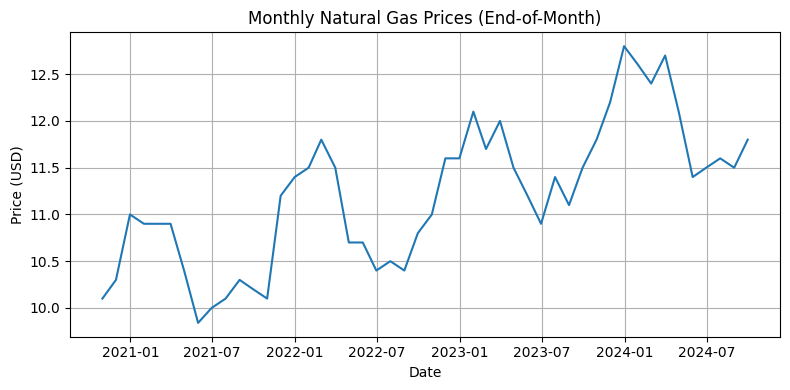

In [18]:
# 📅 Parse Dates and Sort
nat_gas_df = nat_gas_df.reset_index()  # Reset the index to make 'Dates' a column
nat_gas_df['Dates'] = pd.to_datetime(nat_gas_df['Dates'])
nat_gas_df = nat_gas_df.sort_values('Dates').reset_index(drop=True)
nat_gas_df.set_index('Dates', inplace=True)

# 📈 Plot Original Monthly Data
plt.figure(figsize=(8, 4))
plt.plot(nat_gas_df.index, nat_gas_df['Prices'], linestyle='-')
plt.title("Monthly Natural Gas Prices (End-of-Month)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Interpolate to Daily Prices
start_date = nat_gas_df.index.min()
end_date = nat_gas_df.index.max()
daily_index = pd.date_range(start=start_date, end=end_date, freq='D')

interp_func = interp1d(nat_gas_df.index.astype(np.int64), nat_gas_df['Prices'],
                       kind='cubic', fill_value="extrapolate")

interpolated_prices = pd.Series(interp_func(daily_index.astype(np.int64)), index=daily_index)

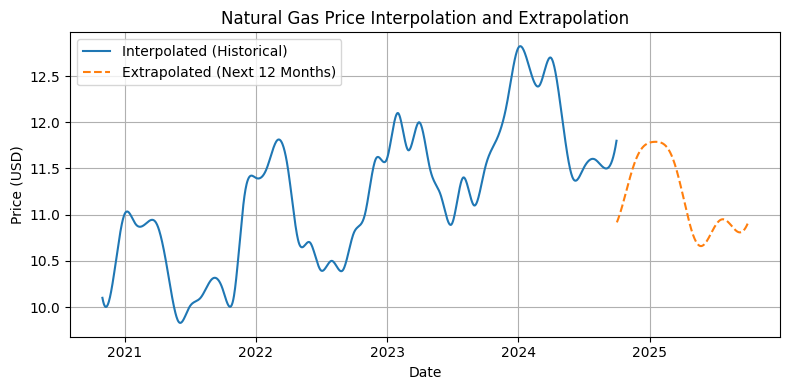

In [14]:
# Fourier Terms for Seasonality Modeling
def create_fourier_terms(dates, period=365.25, order=3):
    t = np.array((dates - dates[0]).days)
    terms = [np.sin(2 * np.pi * k * t / period) for k in range(1, order + 1)]
    terms += [np.cos(2 * np.pi * k * t / period) for k in range(1, order + 1)]
    return np.column_stack(terms)

# Fit Seasonal Model
X = create_fourier_terms(interpolated_prices.index, order=3)
y = interpolated_prices.values
model = LinearRegression().fit(X, y)

# Generate Future Dates (1 year ahead)
future_dates = pd.date_range(start=interpolated_prices.index[-1] + pd.Timedelta(days=1),
                             end=interpolated_prices.index[-1] + pd.DateOffset(years=1),
                             freq='D')

X_future = create_fourier_terms(future_dates, order=3)
future_prices = model.predict(X_future)

# Combine Historical + Forecasted Prices
extended_prices = pd.concat([
    interpolated_prices,
    pd.Series(future_prices, index=future_dates)
])

# Plot Historical + Forecasted Prices
plt.figure(figsize=(8, 4))
plt.plot(interpolated_prices.index, interpolated_prices, label='Interpolated (Historical)')
plt.plot(future_dates, future_prices, label='Extrapolated (Next 12 Months)', linestyle='--')
plt.title("Natural Gas Price Interpolation and Extrapolation")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
 # Estimation Function
def estimate_gas_price(date: str) -> float:
    """
    Returns interpolated or extrapolated price estimate for any date.
    Input date format: 'YYYY-MM-DD'
    """
    dt = pd.to_datetime(date)
    if dt not in extended_prices.index:
        raise ValueError("Date out of supported range (Oct 2020 to Sept 2025)")
    return float(extended_prices.loc[dt])


print("Estimated price on 2023-08-15:", estimate_gas_price("2023-08-15"))
print("Estimated price on 2025-07-01:", estimate_gas_price("2025-07-01"))

Estimated price on 2023-08-15: 11.279046897460354
Estimated price on 2025-07-01: 10.875504687848082


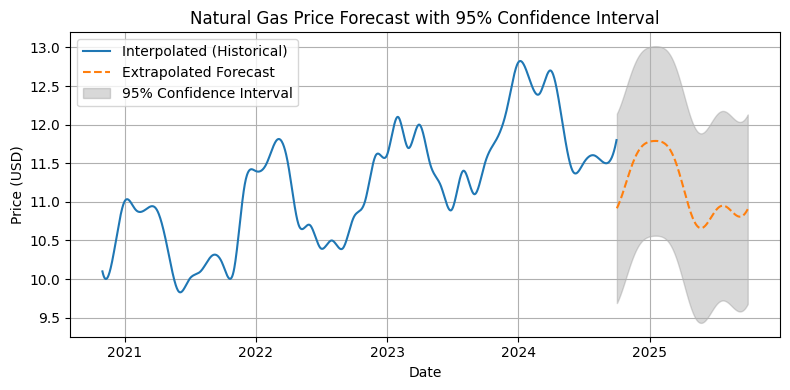

In [15]:
# Compute residuals and standard deviation
y_pred = model.predict(X)
residuals = y - y_pred
residual_std = np.std(residuals)

# 95% Confidence Interval for the forecast
ci_95_upper = future_prices + 1.96 * residual_std
ci_95_lower = future_prices - 1.96 * residual_std

# Plot forecast with confidence bands
plt.figure(figsize=(8, 4))
plt.plot(interpolated_prices.index, interpolated_prices, label='Interpolated (Historical)')
plt.plot(future_dates, future_prices, label='Extrapolated Forecast', linestyle='--')
plt.fill_between(future_dates, ci_95_lower, ci_95_upper, color='gray', alpha=0.3, label='95% Confidence Interval')
plt.title("Natural Gas Price Forecast with 95% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


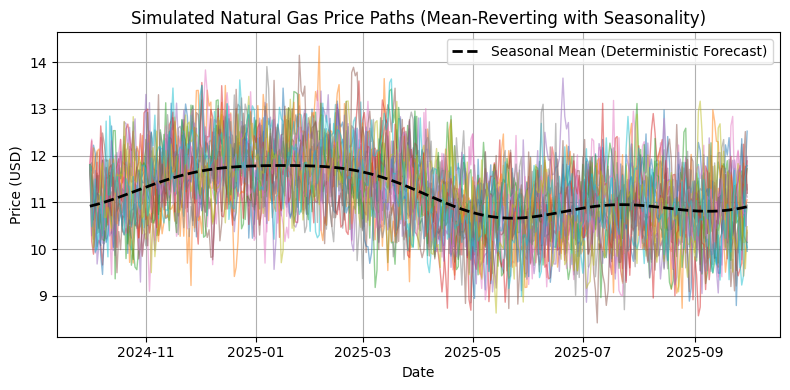

In [16]:
# Parameters for mean-reverting model
kappa = 0.5             # mean reversion speed
sigma = residual_std    # use residuals as volatility estimate
n_paths = 20            # number of simulated paths
n_days = len(future_dates)
dt = 1.0                # 1-day time step

# Seasonal mean from Fourier model (deterministic forecast)
mu_t = future_prices

# Initialize simulation paths
sim_paths = np.zeros((n_paths, n_days))
sim_paths[:, 0] = interpolated_prices.iloc[-1]  # initial value from last known price

# Simulate paths
np.random.seed(42)
for i in range(1, n_days):
    z = np.random.normal(0, 1, n_paths)
    sim_paths[:, i] = sim_paths[:, i-1] + kappa * (mu_t[i] - sim_paths[:, i-1]) * dt + sigma * np.sqrt(dt) * z

# Plot simulation results
plt.figure(figsize=(8, 4))
for i in range(n_paths):
    plt.plot(future_dates, sim_paths[i], alpha=0.5, linewidth=1)

plt.plot(future_dates, mu_t, 'k--', label='Seasonal Mean (Deterministic Forecast)', linewidth=2)
plt.title("Simulated Natural Gas Price Paths (Mean-Reverting with Seasonality)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Second Approach

In [19]:
import os

cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))
print ("os.getcwd() returns an object of type {0}".format(type(cwd)))

# copy the filepath
file_path = "/content/Nat_Gas.csv"
# Changing to the directory containing the file using os.path.dirname() to extract directory
os.chdir(os.path.dirname(file_path)) # Changed line to use directory path from file_path

Current working directory: /content
os.getcwd() returns an object of type <class 'str'>


<ipython-input-23-79d68f574f95>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date_time = pd.to_datetime(date_time)
<ipython-input-23-79d68f574f95>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=['Dates'])
<ipython-input-23-79d68f574f95>:19: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax.plot_date(dates, prices, '-')


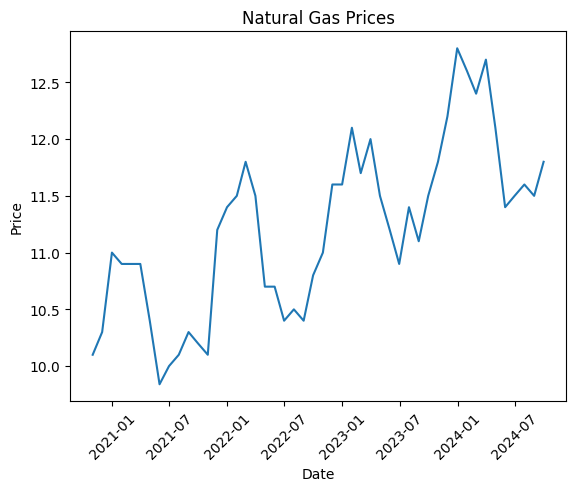

In [23]:
# let's jump into task 1

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date, timedelta

date_time = ["10-2020", "11-2020", "12-2020"]
date_time = pd.to_datetime(date_time)
data = [1, 2, 3]

# Use the file_path variable instead of the string "file_path"
df = pd.read_csv(file_path, parse_dates=['Dates'])
prices = df['Prices'].values
dates = df['Dates'].values

# plot prices against dates
fig, ax = plt.subplots()
ax.plot_date(dates, prices, '-')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Natural Gas Prices')
ax.tick_params(axis='x', rotation=45)

plt.show()

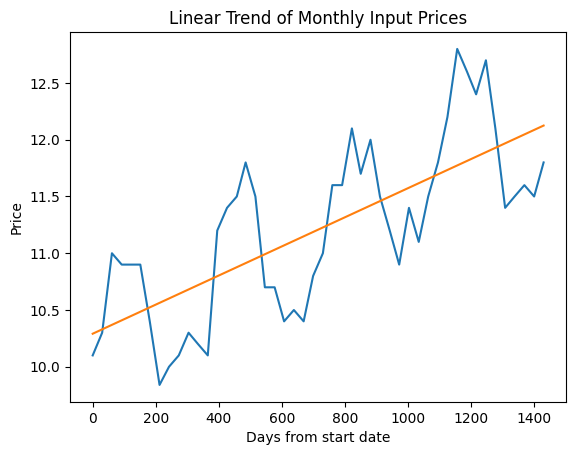

0.001282373598760221 10.29104112595228


In [24]:
# From the plot - we can see the prices have a natural frequency of around a year, but trend upwards.
# We can do a linear regression to get the trend, and then fit a sin function to the variation in each year.

# First we need the dates in terms of days from the start, to make it easier to interpolate later.
start_date = date(2020,10,31)
end_date = date(2024,9,30)
months = []
year = start_date.year
month = start_date.month + 1
while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    if current.month == end_date.month and current.year == end_date.year:
        break
    else:
        month = ((month + 1) % 12) or 12
        if month == 1:
            year += 1

days_from_start = [(day - start_date ).days for day in months]

# Simple regression for the trend will fit to a model y = Ax + B. The estimator for the slope is given by \hat{A} = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2},
# and that for the intercept by \hat{B} = \bar{y} - hat{A} * \xbar

def simple_regression(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x - xbar) * (y - ybar))/ np.sum((x - xbar)**2)
    intercept = ybar - slope*xbar
    return slope, intercept

time = np.array(days_from_start)
slope, intercept = simple_regression(time, prices)

# Plot linear trend
plt.plot(time, prices)
plt.plot(time, time * slope + intercept)
plt.xlabel('Days from start date')
plt.ylabel('Price')
plt.title('Linear Trend of Monthly Input Prices')
plt.show()
print(slope, intercept)

Text(0.5, 1.0, 'Smoothed Estimate of Monthly Input Prices')

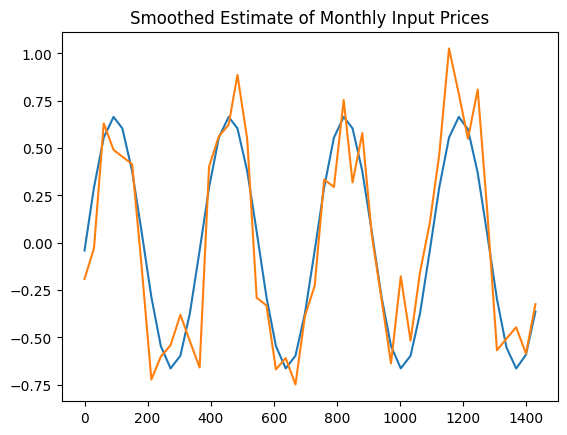

In [26]:
# From this plot we see the linear trend has been captured. Now to fit the intra-year variation.
# Given that natural gas is used more in winter, and less in summer, we can guess the frequency of the price movements to be about a year, or 12 months.
# Therefore we have a model y = Asin( kt + z ) with a known frequency.Rewriting y = Acos(z)sin(kt) + Asin(z)cos(kt),
# we can use bilinear regression, with no intercept, to solve for u = Acos(z), w = Asin(z)

sin_prices = prices - (time * slope + intercept)
sin_time = np.sin(time * 2 * np.pi / (365))
cos_time = np.cos(time * 2 * np.pi / (365))

def bilinear_regression(y, x1, x2):
    # Bilinear regression without an intercept amounts to projection onto the x-vectors
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return(slope1, slope2)

slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)

# We now recover the original amplitude and phase shift as A = slope1 ** 2 + slope2 ** 2, z = tan^{-1}(slope2/slope1)
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)

# Plot smoothed estimate of full dataset
plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift))
plt.plot(time, sin_prices)
plt.title('Smoothed Estimate of Monthly Input Prices')



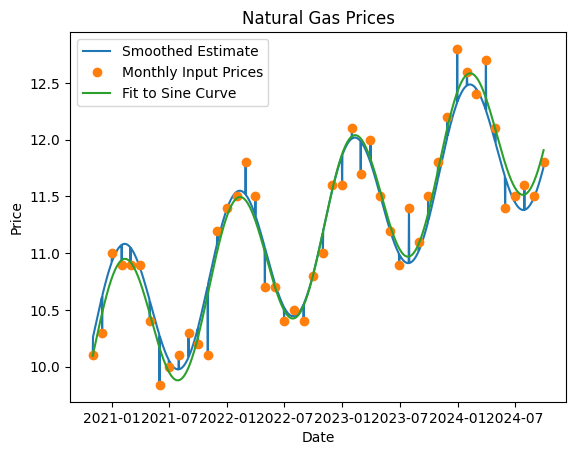

In [27]:
# Define the interpolation/extrapolation function
def interpolate(date):
    days = (date - pd.Timestamp(start_date)).days
    if days in days_from_start:
        # Exact match found in the data
        return prices[days_from_start.index(days)]
    else:
        # Interpolate/extrapolate using the sin/cos model
        return amplitude * np.sin(days * 2 * np.pi / 365 + shift) + days * slope + intercept

# Create a range of continuous dates from start date to end date
continuous_dates = pd.date_range(start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='D')

# Plot the smoothed estimate of the full dataset using interpolation
plt.plot(continuous_dates, [interpolate(date) for date in continuous_dates], label='Smoothed Estimate')

# Fit the monthly input prices to the sine curve
x = np.array(days_from_start)
y = np.array(prices)
fit_amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
fit_shift = np.arctan2(slope2, slope1)
fit_slope, fit_intercept = simple_regression(x, y - fit_amplitude * np.sin(x * 2 * np.pi / 365 + fit_shift))
plt.plot(dates, y, 'o', label='Monthly Input Prices')
plt.plot(continuous_dates, fit_amplitude * np.sin((continuous_dates - pd.Timestamp(start_date)).days * 2 * np.pi / 365 + fit_shift) + (continuous_dates - pd.Timestamp(start_date)).days * fit_slope + fit_intercept, label='Fit to Sine Curve')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices')
plt.legend()
plt.show()